In [11]:
import torch

from torch.utils.data import DataLoader
from torch.optim import Optimizer
from tqdm import tqdm
import numpy as np
import pandas as pd
from src.train.utils import save_test_results, save_train_results
from src.train import _get_loss_name
from datetime import datetime

import albumentations as A
import torch
from torch.optim import Adam
import pandas as pd
from copy import deepcopy
from os.path import join
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, random_split

from src.config import MOT20_EXT_FIRST_AXIS_MEAN, MOT20_EXT_SECOND_AXIS_MEAN, RESULTS_PATH
from src.models import SiameseBasicCNN, models_list
from src.train import ContrastiveLoss, get_config, get_loaders, train_siamese, test_siamese, get_dataset
from src.train.utils import get_model, get_binary_accuracy, draw_reid_predict, get_experiments
from src.train.loss import ContrastiveLoss
from src.transforms import get_norm_transform, get_resize_transform

In [3]:
def train_siamese(
    model: torch.nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    optimizer: Optimizer,
    lr: float,
    criterion,
    epoch_count: int,
    # threshold: float,
    scheduler: None = None,
    device: torch.device = torch.device('cpu'),
    config: dict = None,
):
    """Обучает сиамскую модель с выбранными параметрами.
    Сохраняет результаты обучения в таблицу.
    ### Parameters:
    - model: Module - обучаемая модель
    - train_loader: DataLoader - трейн лоадер
    - val_loader: DataLoader - валидационный лоадер
    - optimizer: Optimizer - оптимизационный метод
    - criterion - лосс-функция
    - epoch_count: int - кол-во эпох. нумерация начинается с нулевой
    - scheduler - планировщик lr
    - threshold: float - порог, разбивающий предсказания для батча. 
        Все предсказание предварительно нормализуется в границах [0;1] 
    - device: device - устройство
    - config: dict - конфигурация датасета
    """
    losses_train = []
    accuracies_train = []
    losses_val = []
    accuracies_val = []
    best_val_accuracy = 0
    best_val_loss = 1e10
    thresholds = []
    dt = None

    for epoch in range(epoch_count):
        print('Epoch {}/{}:'.format(epoch, epoch_count - 1), flush=True)
        for phase in ['train', 'val']:
            if (phase == 'train'):
                dataloader = train_loader
                if (scheduler is not None):
                    scheduler.step()
                model.train()
            else:
                dataloader = val_loader
                model.eval()

            running_loss = 0.

            predictions = torch.tensor([[], []])
            for (x1, x2, y) in tqdm(dataloader):
                x1, x2, y = x1.to(device), x2.to(device), y.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    distance = model(x1, x2)
                    loss = criterion(distance, y)

                    if (phase == 'train'):
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item()
                if (phase == 'val'):
                    # батч с предсказанием сохраняется
                    d = distance.clone().cpu()
                    yy = y.clone().cpu()
                    a, b = torch.tensor(np.asarray(
                        d)), torch.tensor(np.asarray(yy))
                    a = a.reshape(-1)
                    predictions = torch.hstack(
                        [predictions, torch.vstack([a, b])])
                # running_acc += get_distance_accuracy(
                #     distance.clone(), y, threshold)

            epoch_loss = running_loss / len(dataloader)
            # epoch_acc = running_acc / len(dataloader)
            if phase == 'val':
                df = pd.DataFrame(predictions.T, columns=[
                                  'predicted', 'actual'])
                class_zero_val = df[df['actual'] == 0]['predicted']
                class_ones_val = df[df['actual'] == 1]['predicted']
                threshold = (class_zero_val.mean() + class_zero_val.mean()) / 2
                # вычисление аккураси
                FP = len(class_zero_val[class_zero_val > threshold])
                FN = len(class_ones_val[class_ones_val < threshold])
                epoch_acc = 1 - (FP + FN) / \
                    (len(class_zero_val) + len(class_ones_val))
                losses_val.append(epoch_loss)
                accuracies_val.append(epoch_acc)
                thresholds.append(threshold)
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    phase, epoch_loss, epoch_acc), flush=True)
            else:
                losses_train.append(epoch_loss)
                # accuracies_train.append(epoch_acc)

            if phase == 'val' and (best_val_accuracy < epoch_acc
                                   or (best_val_accuracy == epoch_acc and epoch_loss < best_val_loss)):
                best_val_accuracy = epoch_acc
                best_val_loss = epoch_loss
                dt = datetime.now()
                torch.save({
                    'epoch': epoch,
                    'threshold': threshold,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': epoch_loss,
                    'model_name': model.name,
                }, f'./models/{model.name}_{dt.strftime("%d.%m_%H:%M:%S")}.pth')
                print(f'Model saved at {model.name}.pth')

    save_train_results(
        model_name=model.name,
        datetime=dt,
        epoch_count=epoch_count,
        lr=lr,
        optimizer=str(optimizer).split(' ')[0],
        loss_name=_get_loss_name(criterion),
        val_losses=losses_val,
        val_accuracies=accuracies_val,
        gamma=scheduler.gamma if (scheduler) else -1,
        step_size=scheduler.step_size if (scheduler) else -1,
        config=config,
        extra_parameters={
            'thresholds': ';'.join(map(str, list(thresholds)))
        },
        train_accuracies=accuracies_train,
        train_losses=losses_train
    )

    return model, {
        'train': (losses_train, accuracies_train),
        'val': (losses_val, accuracies_val)
    }

In [4]:
# sd = torch.load(f=f'models/basic_cnn_20.05_16:29.pth')
torch.cuda.is_available()

False

In [6]:
resize_transform = get_resize_transform((MOT20_EXT_FIRST_AXIS_MEAN, MOT20_EXT_SECOND_AXIS_MEAN)) 
norm_transform = get_norm_transform()
transform = A.Compose([resize_transform, norm_transform])
dataset_config = get_config('mot20_ext-v1d')
train_loader, val_loader, _ = get_loaders(dataset_config, transform=transform)

/home/nick/reidentification/.venv/lib/python3.10/site-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 2 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


In [7]:
torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [8]:
model = deepcopy(models_list['basic_cnn']).to(device)
lr = 1e-2
optimizer = Adam(model.parameters(), lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
criterion = ContrastiveLoss(margin=1.5)
epoch_count = 4
model, results = train_siamese(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    lr=lr,
    criterion=criterion,
    epoch_count=epoch_count,
    config=dataset_config,
    device=device,
)

Epoch 0/3:


100%|██████████| 21/21 [00:02<00:00, 10.49it/s]

val Loss: 0.8979 Acc: 0.8393
Model saved at basic_cnn.pth
Epoch 1/3:



100%|██████████| 21/21 [00:01<00:00, 12.86it/s]

val Loss: 0.8975 Acc: 0.8452
Model saved at basic_cnn.pth
Epoch 2/3:



100%|██████████| 21/21 [00:02<00:00,  8.71it/s]

val Loss: 0.8943 Acc: 0.8780
Model saved at basic_cnn.pth
Epoch 3/3:



100%|██████████| 21/21 [00:01<00:00, 11.99it/s]

val Loss: 0.8889 Acc: 0.8363


In [9]:
test_dataset_config = get_config('mot20_ext-test-v2')
test_set, _ = random_split(get_dataset(test_dataset_config, transform), [
                          test_dataset_config['dataset_use'], 1 - test_dataset_config['dataset_use']])
test_loader = DataLoader(test_set)

In [ ]:
# model = get_model(best1)
# threshold1 = float(best1['extra_parameters'].item().split('=')[1].split(',')[0])
# threshold1

In [10]:
td1 = test_siamese(model, test_loader, device)

100%|██████████| 6946/6946 [00:41<00:00, 167.16it/s]


In [15]:
def get_optimal_threshold(result):
    threshold = list(result['extra_parameters'].item().split('=')[1].split(';'))
    best_acc = result['best_val_acc']
    acc = list(map(float, result['val_accuracies'].item().split(';')))
    i = acc.index(best_acc.item())
    threshold = float(threshold[i])
    return threshold

In [14]:
df = get_experiments()
current = df[df['datetime'] == '2023-05-20 20:45:12.065621']
current

,model_name,datetime,epoch_count,optimizer,lr,gamma,step_size,loss_name,val_losses,val_accuracies,best_val_acc,best_val_loss,test_accuracy,dataset_config,extra_parameters,train_losses,train_accuracies
32,basic_cnn,2023-05-20 20:45:12.065621,4,Adam,0.01,NaN,NaN,ContrastiveLoss m=1.5,0.8978820698601859;0.8975228539534977;0.894302...,0.8392857142857143;0.8452380952380952;0.877976...,0.877976,0.888933,NaN,mot20_ext-v1d,thresholds=0.03124382719397545;0.0170922894030...,0.8601969254427942;0.8165868085691299;0.797321...,NaN


In [30]:
threshold = get_optimal_threshold(current)
threshold

0.04042518511414528

0.8797869277281889

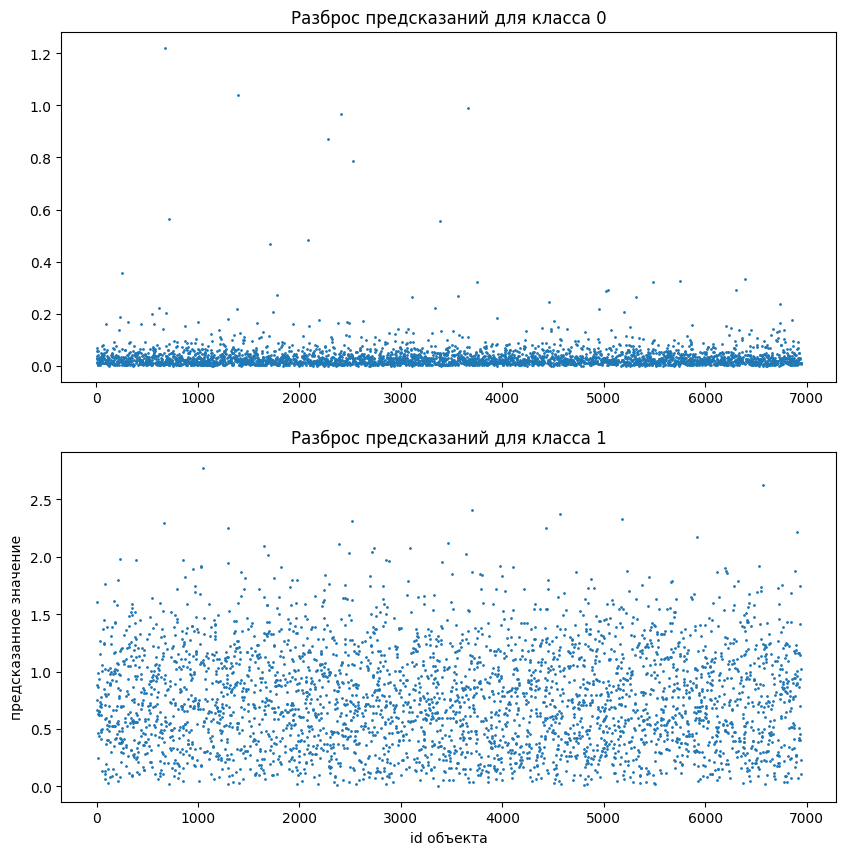

In [21]:
draw_reid_predict(td1)
get_binary_accuracy(td1, threshold)

In [28]:
def get_model(df: pd.DataFrame):
    """Возвращает загруженную модель
    ### Parameters:
     - df: DataFrame - таблица с данными о моделями. Ожидается таблица с одной строкой, берется строка по индексу 0
    """
    data = df.iloc[0]
    model = deepcopy(models_list[data['model_name']])
    name = f'{data["model_name"]}_{datetime.strptime(data["datetime"], "%Y-%m-%d %H:%M:%S.%f").strftime("%d.%m_%H:%M")}.pth'
    state_dict = torch.load(f=f'models/{name}')
    model.load_state_dict(state_dict=state_dict['model_state_dict'])
    return model, state_dict

In [31]:
loaded_model, sd = get_model(current)
loaded_model

SiameseBasicCNN(
  (cnn1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (fc1): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): Tanh()
    (2): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [32]:
loaded_model.eval()
td2 = test_siamese(loaded_model, test_loader, device)

100%|██████████| 6946/6946 [00:37<00:00, 185.89it/s]


0.878635185718399

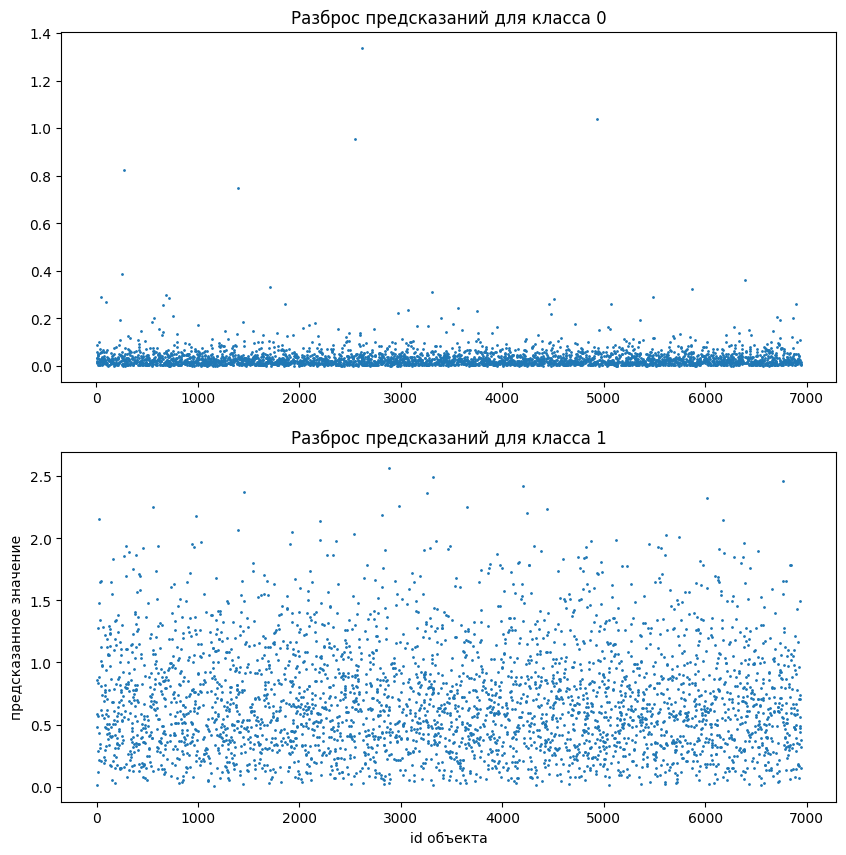

In [33]:
draw_reid_predict(td2)
get_binary_accuracy(td2, threshold)